<a href="https://colab.research.google.com/github/chardiwall/DPSNN/blob/main/DPSNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Discription
**Title:** DPSNN (A Differentially Private Spiking Neural Network with Temporal Enhanced Polling).

**Objectives:** Implementation of the [paper](https://arxiv.org/pdf/2205.12718.pdf).

**Discription:** The project is set in the context of the growing field of social robotics, which involves the deployment of robots in human-centric environments. These environments can range from healthcare facilities and educational institutions to customer service and domestic settings. The unique aspect of this project lies in its focus on privacy-preserving mechanisms, an increasingly critical concern in today's data-driven world.


[GitHub Link](https://github.com/chardiwall/DPSNN)

---
## Frameworks
SNN Framwork: [SNNTorch](https://snntorch.readthedocs.io/en/latest/)

DP Framwork: [Opacus](https://github.com/pytorch/opacus)

Neuromorphic Dataset Framewrok: [Tonic](https://github.com/neuromorphs/tonic)

---
## Datasets

| Static      | Neuromorphic |
--------------|----------------
| [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)      |[N-MNIST](https://www.garrickorchard.com/datasets/n-mnist#h.p_ID_38) |
| [MNIST](https://yann.lecun.com/exdb/mnist/)      | [CIFAR10-DVS](https://figshare.com/articles/dataset/CIFAR10-DVS_New/4724671/2) |
| [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)      |   |

---


# Loading Essential Libraries

In [1]:
!pip install -q opacus
!pip install -q snntorch
!pip install -q tonic
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 838.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
import os
import sys
from copy import copy

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from torchvision import datasets, transforms

import tonic

import snntorch as snn
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils, surrogate

from opacus import PrivacyEngine


## Loading Datasets

<details>
<summary>Unzipping and Loading Data</summary>

    base_dir_path = '/content/drive/MyDrive/Colab Notebooks/DPSNN/N-MNIST/'
    train_zip_name = 'Copy of Train'
    test_zip_name = 'Copy of Test'
    for zip_file in [train_zip_name, test_zip_name]:
    zip_path = os.path.join(base_dir_path, zip_file+'.zip')
    with ZipFile(zip_path, 'r') as zip_ref:
        extraction_path = os.path.join(base_dir_path, zip_file)
        if not (os.path.exists(extraction_path)):
        os.mkdir(extraction_path)
        zip_ref.extractall(base_dir_path)

    # CIFAR10-DVS
    base_dir_path = '/content/drive/MyDrive/Colab Notebooks/DPSNN/CIFAR10-DVS'
    file_name = 'CIFAR10-DVS.zip'
    with ZipFile(os.path.join(base_dir_path, file_name), 'r') as zip_ref:
        zip_ref.extractall(base_dir_path)

</details>


In [3]:
def fetch_data(name='mnist', batch_size=64, shuffle=True):
    """
    Loads and returns data loaders for a given dataset.

    Args:
        name (str): Name of the dataset to be loaded. Supported datasets are 'mnist', 'fashion-mnist', 'cifar-10', 'nmnist', and 'cifar-10-dvs'.
        batch_size (int, optional): Number of samples per batch to load.
        shuffle (bool, optional): Whether to shuffle the dataset at every epoch.

    Returns:
        Tuple[DataLoader, DataLoader]: A tuple containing training and test data loaders.
    """

    name = name.lower()

    # Handling static datasets: MNIST, Fashion-MNIST, and CIFAR-10
    if name in ['mnist', 'fashion-mnist', 'cifar-10']:

        # Define a common transformation pipeline for the static datasets
        transform = transforms.Compose([
            transforms.Resize(size=(28, 28)),  # Resize images to 28x28 pixels
            transforms.Grayscale(),  # Convert images to grayscale
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Normalize((0,), (1,))  # Normalize tensors
        ])

        # Load MNIST dataset
        if name == 'mnist':
            train = datasets.MNIST(root='.', train=True, transform=transform, download=True)
            test = datasets.MNIST(root='.', train=False, transform=transform, download=True)

        # Load Fashion MNIST dataset
        elif name == 'fashion-mnist':
            train = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
            test = datasets.FashionMNIST(root='.', train=False, transform=transform, download=True)

        # Load CIFAR-10 dataset
        elif name == 'cifar-10':
            train = datasets.CIFAR10('.', train=True, transform=transform, download=True)
            test = datasets.CIFAR10('.', train=False, transform=transform, download=True)

        # Create data loaders for training and testing sets
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, drop_last=True)
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, drop_last=True)

    # Handling neuromorphic datasets: NMNIST and CIFAR-10-DVS
    elif name in ['nmnist', 'cifar-10-dvs']:
        # Determine sensor size based on the dataset
        sensor_size = tonic.datasets.NMNIST.sensor_size if name == 'nmnist' else tonic.datasets.CIFAR10DVS.sensor_size

        # Define a transformation pipeline for neuromorphic datasets
        transform = tonic.transforms.Compose([
            tonic.transforms.Denoise(filter_time=10000),  # Apply denoising with a 10ms filter
            tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=1000)  # Convert events to frames
        ])

        # Load NMNIST dataset
        if name == 'nmnist':
            train = tonic.datasets.NMNIST('.', train=True, transform=transform)
            test = tonic.datasets.NMNIST('.', train=False, transform=transform)

        # Load CIFAR-10-DVS dataset
        else:
            train = tonic.datasets.CIFAR10DVS('.', train=True, transform=transform)
            test = tonic.datasets.CIFAR10DVS('.', train=False, transform=transform)

        # Create data loaders for training and testing sets
        # Note: `collat_fn` should be `collate_fn`
        train_loader = DataLoader(train, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle = shuffle)
        test_loader = DataLoader(test, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first = False))
    else:
        raise Exception(f'Error! {name} dataset not found...')

    return train_loader, test_loader


# Building SNN Architectures


<details>
<summary> Show Code Block </summary>
```
class SNN(nn.Module):
  def __init__(self):
    super().__init__()

    # First convolutional block
    self.cb_01 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 12, kernel_size = 5),
        nn.GroupNorm(num_groups = 6, num_channels= 12),
        snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),
    )

    # Second convolutional block
    self.cb_02 = nn.Sequential(
        nn.Conv2d(in_channels = 12, out_channels = 64, kernel_size = 5),
        nn.GroupNorm(num_groups = 8, num_channels = 64),
        snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),
    )

    # Average pooling layer
    self.pooling = nn.AvgPool2d(3)

    # Third convolutional block
    self.cb_03 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5),
        nn.GroupNorm(num_groups = 8, num_channels = 128),
        snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),
    )

    # Fully Connected Layer
    self.FC = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 128 * 2 * 2, out_features= 10),
        snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True, output=True)
    )
    
  def forward(self, x):
    # Forward pass through the network
    x = self.cb_01(x)
    x = self.cb_02(x)
    x = self.pooling(x)
    x = self.cb_03(x)
    x = self.FC(x)

    return x
```
</details>

In [4]:
# using gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [26]:
def fetch_model(model_name = 'mnist', show_summary = True, batch_size = -1):
    """
    Creates and returns a neural network model based on the specified model name.

    Args:
        model_name (str, optional): Name of the model to fetch. Supported models are 'mnist', 'fashion-mnist', 'nmnist', 'cifar-10', and 'cifar-10-dvs'.
        show_summary (bool, optional): If True, prints a summary of the model, detailing layers, output shapes, and parameter counts.
        batch_size (int, optional): Specifies the batch size for the model summary. This does not affect model architecture.

    Returns:
        torch.nn.Module: The constructed neural network model.
    """
    model_name = model_name.lower()

    # Check if the model name is for MNIST, Fashion-MNIST, or NMNIST datasets
    if model_name in ['mnist', 'fashion-mnist', 'nmnist']:
        in_channels, in_feature = (2, 1600) if model_name == 'nmnist' else (1, 1024)
        net = nn.Sequential(
            # First convolution block
            nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 7),
            # nn.GroupNorm(num_groups = 8, num_channels= 32),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(2),

            #Second convolution block
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4),
            # nn.GroupNorm(num_groups = 8, num_channels = 64),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(2),

            # Fully connected or output block
            nn.Flatten(),
            nn.Linear(in_features = in_feature, out_features= 10),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True, output=True)
        )

    # Check if the model name is for CIFAR-10 dataset
    elif model_name == 'cifar-10':
        net = nn.Sequential(
            # First convolution block
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 64),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Second convolution block
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 64),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(5),

            # Third convolution block
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 128),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Forth convolution block
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 128),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(5),

            # Fifth convolution block
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 128),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Sixth convolution block
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 128),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(5),

            # Seventh convolution block
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 256),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # eighth convolution block
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 256),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(4),

            # Fully connected or output block
            nn.Flatten(),
            nn.Linear(in_features = 256 * 4 * 4, out_features= 10),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True, output=True)
            )

    # Check if the model name is for CIFAR-10-DVS dataset
    elif model_name == 'cifar-10-dvs':
        net = nn.Sequential(
            # First convolution block
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 64),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Second convolution block
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 64),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(4),

            # Third convolution block
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 128),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(4),

            # Forth convolution block
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 256),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Fifth convolution block
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 256),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(4),

            # Sixth convolution block
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 512),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(4),

            # Seventh convolution block
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 1024),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Fifth convolution block
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1),
            nn.GroupNorm(num_groups = 8, num_channels= 1024),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

            # Pooling
            nn.AvgPool2d(4),

            # Fully connected or output block
            nn.Flatten(),
            nn.Linear(in_features = 1024 * 4 * 4, out_features= 10),
            snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True, output=True)
        )

    net = net.to(device)


    # If requested, print a summary of the model showing layer details, output shapes, and parameter counts
    if show_summary:
        input_size = (2, 34, 34) if model_name in ['nmnist', 'cifar-10-dvs'] else (1, 28, 28)
        summary(net, input_size = input_size, batch_size = batch_size, device = str(device))

    return net

# Training the Network

In [6]:
def plot_training_history(history):
    '''
    Plots the training and testing accuracy and loss as a function of epochs.
    This function provides insight into the learning behavior of the model and helps in diagnosing issues like overfitting or underfitting.

    Args:
        history (dict): A dictionary containing 'Training Accuracy', 'Testing Accuracy', 'Training Loss', and 'Testing Loss' as keys with lists of their values per epoch.
    '''

    # Setting the style of seaborn for more beautiful plots
    sns.set(style="whitegrid")

    # Setting up the matplotlib figure with a certain size
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # Plotting Training and Testing Accuracy
    axes[0].plot(history['Training Accuracy'], label='Training Accuracy')
    axes[0].plot(history['Testing Accuracy'], label='Testing Accuracy')
    axes[0].set_title('Training and Testing Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(0, 1)  # Set the limit for y-axis from 0 to 1
    axes[0].legend()

    # Plotting Training and Testing Loss
    axes[1].plot(history['Training Loss'], label='Training Loss')
    axes[1].plot(history['Testing Loss'], label='Testing Loss')
    axes[1].set_title('Training and Testing Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')

    axes[1].legend()

    # Displayinf the plots
    plt.tight_layout()
    plt.show()

In [7]:
# Feed forward pass function for static dataset
def fwrd_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net
  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

# Feed forward pass function for neuromorphic dataset
def neuro_fwrd_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [9]:
def train_network(dataset_name, epochs = 2, lr=1e-3, betas=(0.9, 0.999), batch_size = 64, shuffle=True, dp=None):
    """
    Trains a neural network on a specified dataset, with options for differential privacy.

    Args:
        dataset_name (str): Name of the dataset to use for training and evaluation.
        epochs (int, optional): Number of training epochs. Defaults to 2.
        lr (float, optional): Learning rate for the optimizer. Defaults to 1e-3.
        betas (tuple, optional): Coefficients used for computing running averages of gradient and its square.
        batch_size (int, optional): Batch size for data loading. Defaults to 64.
        shuffle (bool, optional): Whether to shuffle the dataset. Defaults to True.
        dp (optional): Settings for differential privacy. If provided, differential privacy mechanisms are applied.

    Returns:
        (torch.nn.Module, dict): Trained model and history of training/testing accuracy and loss.
    """

    target_name = copy(dataset_name)

    # Initialize a dictionary to store training and testing metrics
    history = {
        'Training Accuracy': [],
        'Testing Accuracy': [],
        'Training Loss': [],
        'Testing Loss': []
    }

    # Loading required dataset
    train_loader, test_loader = fetch_data(name=dataset_name, batch_size=batch_size, shuffle=shuffle)

    # Initializing the model based on dataset
    net = fetch_model(dataset_name, show_summary = True, batch_size = batch_size)

    # Defining loss function and optimizer
    loss = SF.ce_rate_loss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, betas=betas)



    # configuring the privacy engine if differential privacy is required
    if dp:
        privacy_engine = PrivacyEngine(accountant = 'rdp')
        print( "Are Model, Optimzer and Data_Loader compatible with opacus framework:",
            privacy_engine.is_compatible(module = net, optimizer = optimizer, data_loader = train_loader))

        # Configure only the optimizer for differential privacy
        _, optimizer, _ = privacy_engine.make_private_with_epsilon(
            module=net,
            optimizer=optimizer,
            data_loader=train_loader,
            epochs = epochs,
            max_grad_norm = dp['c'], # 'c' is a hyperparameter for clipping gradients
            target_delta = dp['delta'],
            target_epsilon = dp['target_ep']
        )
        history['epsilon'] = []
        target_name += '_with_dp'

    # Training and evaluation loop
    for epoch in range(epochs):
        net.train()
        train_acc, train_loss, train_acc_total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            if dataset_name in ['nmnist', 'cifar-10-dvs']:
                spk_rec = neuro_fwrd_pass(net, X)
            else:
                spk_rec, _ = fwrd_pass(net, 10, X)

            loss_val = loss(spk_rec, y)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            train_acc += SF.accuracy_rate(spk_rec, y) * spk_rec.size(1)
            train_acc_total += spk_rec.size(1)
            train_loss += loss_val.item()

    net.eval()
    test_acc, test_loss, test_acc_total = 0, 0, 0

    with torch.inference_mode():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            if dataset_name in ['nmnist', 'cifar-10-dvs']:
                spk_rec = neuro_fwrd_pass(net, X)
            else:
                spk_rec, _ = fwrd_pass(net, 10, X)

            loss_val = loss(spk_rec, y)

            test_acc += SF.accuracy_rate(spk_rec, y) * spk_rec.size(1)
            test_acc_total += spk_rec.size(1)
            test_loss += loss_val.item()

    history['Training Accuracy'].append(train_acc / train_acc_total)
    history['Testing Accuracy'].append(test_acc / test_acc_total)
    history['Training Loss'].append(train_loss / len(train_loader))
    history['Testing Loss'].append(test_loss / len(test_loader))
    print(f'Epoch {epoch}: Train Acc: {train_acc / train_acc_total:.2f}, Test Acc: {test_acc / test_acc_total:.2f}, Train Loss: {train_loss / len(train_loader):.2f}, Test Loss: {test_loss / len(test_loader):.2f}')
    if dp:
        epsilon = privacy_engine.get_epsilon(delta=dp['delta'])
        history['epsilon'].append(epsilon)

        print(f"(ε = {epsilon:.2f}, δ = {dp['delta']})")

    np.save(target_name+'.npy', history)
    torch.save(net, target_name+'.pt')

    return net, history

## MNIST

In [ ]:
dp = {
    'c': 2,
    'delta': 1e-5,
    'target_ep': 3,
}

100%|██████████| 9912422/9912422 [00:00<00:00, 116910169.10it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26379724.26it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32050956.99it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19281911.71it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch 0: Train Acc: 0.15, Test Acc: 0.21, Train Loss: 2.29, Test Loss: 2.26
Epoch 1: Train Acc: 0.38, Test Acc: 0.52, Train Loss: 2.21, Test Loss: 2.16
Epoch 2: Train Acc: 0.70, Test Acc: 0.78, Train Loss: 2.09, Test Loss: 2.03
Epoch 3: Train Acc: 0.77, Test Acc: 0.78, Train Loss: 1.99, Test Loss: 1.94
Epoch 4: Train Acc: 0.77, Test Acc: 0.78, Train Loss: 1.91, Test Loss: 1.86
Epoch 5: Train Acc: 0.78, Test Acc: 0.81, Train Loss: 1.83, Test Loss: 1.79
Epoch 6: Train Acc: 0.83, Test Acc: 0.86, Train Loss: 1.78, Test Loss: 1.74
Epoch 7: Train Acc: 0.87, Test Acc: 0.88, Train Loss: 1.73, Test Loss: 1.71
Epoch 8: Train Acc: 0.88, Test Acc: 0.89, Train Loss: 1.70, Test Loss: 1.68
Epoch 9: Train Acc: 0.89, Test Acc: 0.91, Train Loss: 1.68, Test Loss: 1.66
Epoch 10: Train Acc: 0.90, Test Acc: 0.91, Train Loss: 1.66, Test Loss: 1.65
Epoch 11: Train Acc: 0.91, Test Acc: 0.92, Train Loss: 1.65, Test Loss: 1.63
Epoch 12: Train Acc: 

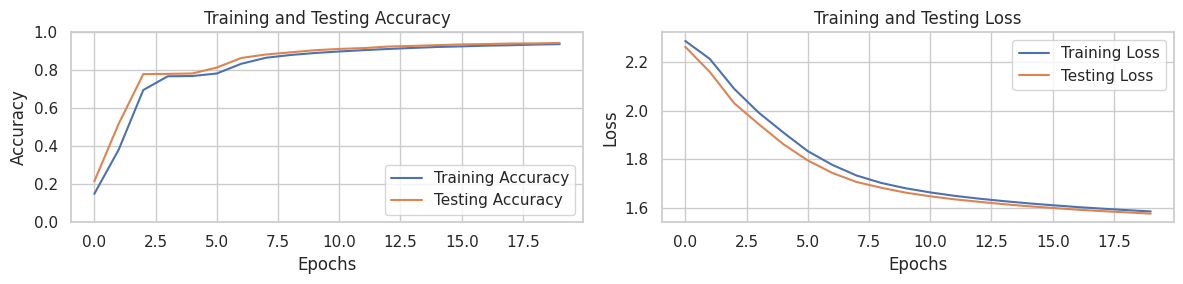

In [ ]:
mnist_net, mnist_net_history = train_network(dataset_name = 'mnist', lr = 0.005, epochs = 20, batch_size = 1024)

plot_training_history(mnist_net_history)

## MNIST with DP

Epoch 0: Train Acc: 0.15, Test Acc: 0.29, Train Loss: 2.28, Test Loss: 2.20
(ε = 3.18, δ = 1e-05)
Epoch 1: Train Acc: 0.40, Test Acc: 0.49, Train Loss: 2.12, Test Loss: 2.01
(ε = 3.69, δ = 1e-05)
Epoch 2: Train Acc: 0.60, Test Acc: 0.66, Train Loss: 1.93, Test Loss: 1.84
(ε = 4.09, δ = 1e-05)
Epoch 3: Train Acc: 0.67, Test Acc: 0.72, Train Loss: 1.83, Test Loss: 1.79
(ε = 4.44, δ = 1e-05)
Epoch 4: Train Acc: 0.75, Test Acc: 0.82, Train Loss: 1.77, Test Loss: 1.70
(ε = 4.75, δ = 1e-05)
Epoch 5: Train Acc: 0.85, Test Acc: 0.91, Train Loss: 1.68, Test Loss: 1.62
(ε = 5.04, δ = 1e-05)
Epoch 6: Train Acc: 0.91, Test Acc: 0.92, Train Loss: 1.61, Test Loss: 1.59
(ε = 5.31, δ = 1e-05)
Epoch 7: Train Acc: 0.92, Test Acc: 0.93, Train Loss: 1.59, Test Loss: 1.58
(ε = 5.57, δ = 1e-05)
Epoch 8: Train Acc: 0.92, Test Acc: 0.93, Train Loss: 1.59, Test Loss: 1.58
(ε = 5.82, δ = 1e-05)
Epoch 9: Train Acc: 0.92, Test Acc: 0.93, Train Loss: 1.58, Test Loss: 1.57
(ε = 6.05, δ = 1e-05)
Epoch 10: Train Acc:

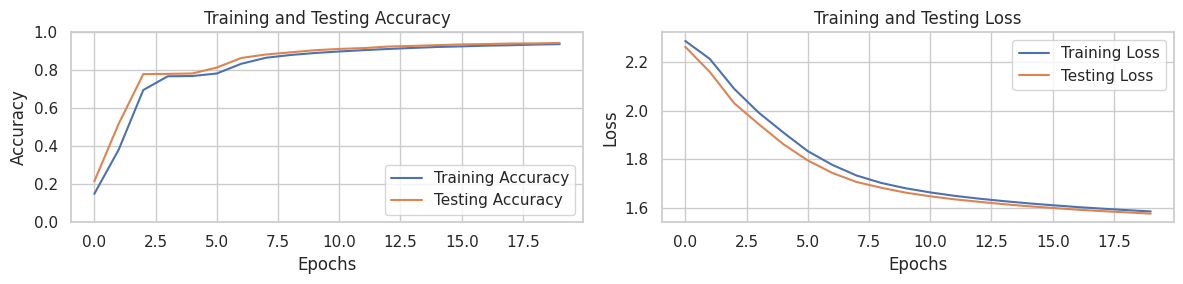

In [ ]:
mnist_net_dp, mnist_net_dp_history = train_network(dataset_name = 'mnist', lr = 0.005, epochs = 20, batch_size = 1024, dp = dp)

plot_training_history(mnist_net_dp_history)

## Fashion-MNIST

In [ ]:
fmnist_net, fmnist_net_history = train_network(dataset_name = 'fashion-mnist', lr = 0.005, epochs = 20, batch_size = 1024)

plot_training_history(fmnist_net_history)

## Fashion-MNIST with DP

In [ ]:
fmnist_net_dp, fmnist_net_dp_history = train_network(dataset_name = 'fashion-mnist', lr = 0.005, epochs = 20, batch_size = 1024, dp = dp)

plot_training_history(fmnist_net_dp_history)

## NMNIST

In [ ]:
nmnist_net, nmnist_net_history = train_network(dataset_name = 'mnist', lr = 0.005, epochs = 20, batch_size = 512)

plot_training_history(nmnist_net_history)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 32, 28, 28]           3,168
         GroupNorm-2           [16, 32, 28, 28]              64
             Leaky-3           [16, 32, 28, 28]               0
         AvgPool2d-4           [16, 32, 14, 14]               0
            Conv2d-5           [16, 64, 11, 11]          32,832
         GroupNorm-6           [16, 64, 11, 11]             128
             Leaky-7           [16, 64, 11, 11]               0
         AvgPool2d-8             [16, 64, 5, 5]               0
           Flatten-9                 [16, 1600]               0
           Linear-10                   [16, 10]          16,010
            Leaky-11       [[-1, 10], [-1, 10]]               0
Total params: 52,202
Trainable params: 52,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/ba

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


## NMNIST with DP

In [ ]:
nmnist_net_dp, nmnist_net_dp_history = train_network(dataset_name = 'nmnist', lr = 0.005, epochs = 20, batch_size = 512, dp = dp)

plot_training_history(nmnist_net_dp_history)

## CIFAR-10

In [ ]:
dp = {
    'c': 6,
    'delta': 1e-5,
    'target_ep': 8,
}

In [ ]:
cifar10_net, cifar10_net_history = train_network(dataset_name = 'cifar-10', lr = 0.001, epochs = 80, batch_size = 1024)

plot_training_history(cifar10_net_history)

## CIFAR-10 with DP

In [ ]:
cifar10_net_dp, cifar10_net_dp_history = train_network(dataset_name = 'cifar-10', lr = 0.001, epochs = 80, batch_size = 1024, dp = dp)

plot_training_history(cifar10_net_dp_history)

## CIFAR-10-DVS

In [ ]:
dp = {
    'c': 6,
    'delta': 1e-5,
    'target_ep': 8,
}

In [ ]:
cifar10dvs_net, cifar10dsv_net_history = train_network(dataset_name = 'cifar-10-dvs', lr = 0.001, epochs = 80, batch_size = 1024)

plot_training_history(cifar10dsv_net_history)

## CIFAR-10-DVS with DP

In [ ]:
cifar10dvs_net_dp, cifar10dvs_net_dp_history = train_network(dataset_name = 'cifar-10-dvs', lr = 0.001, epochs = 80, batch_size = 1024, dp = dp)

plot_training_history(cifar10dvs_net_dp_history)

---